In [1]:
import os
import math
import numpy as np
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)
# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
df = pd.read_csv('PGE_SA.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Data'] = pd.to_datetime(df['Data'])
df = df.rename(columns={'Maks.':'Maks'})
df = df.rename(columns={'Min.':'Min'})
df.head()

,Data,Otwarcie,Zamknięcie,Maks,Min,Obrót (mln. zł),Zmiana (%)
0,2012-04-19,14.05,14.24,14.40,13.99,70.06,0.00
1,2012-04-20,14.24,14.35,14.42,14.20,39.45,0.75
2,2012-04-23,14.24,14.06,14.34,13.91,37.70,-2.01
3,2012-04-24,13.92,13.86,14.04,13.85,28.37,-1.40
4,2012-04-25,13.92,13.93,14.16,13.87,48.42,0.44


### Shift label column

In [3]:
for i in range(1, 31):
    name = 'Otwarcie_' + str(i) + 'day'
    df[name] = df['Otwarcie'].shift(-i)
    name = 'Zamknięcie_' + str(i) + 'day'
    df[name] = df['Zamknięcie'].shift(i)

### Drop invalid samples

In [4]:
df = df.iloc[31:]
df = df[:-30]
df.index = range(len(df))

### Split data

In [5]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Data, y=train_df.Otwarcie, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Data, y=test_df.Otwarcie, name='Test'))
fig.show()

### Drop unnecessary columns

In [6]:
drop_cols = ['Data', 'Obrót (mln. zł)', 'Zmiana (%)', 'Otwarcie', 'Min', 'Maks']

train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

## 1 day ahead

7 days of history data

In [7]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune RandomForestRegressor

In [8]:
param_grid={'bootstrap': [True],
 'max_depth': [20, 30, 40, 50, 60],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}
tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = tscv, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [9]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.08210750367315461
MAE = 0.17745911885245735
RMSE = 0.28654406933865273


In [11]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_pred,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

30 days of history data

In [12]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune RandomForestRegressor

In [13]:
param_grid={'bootstrap': [True],
 'max_depth': [20, 30, 40, 50, 60],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}
tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = tscv, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}

In [14]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.5209417808330428
MAE = 0.48515999893918593
RMSE = 0.7217629672081013


In [16]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_pred,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

## 7 days ahead

7 days of history data

In [17]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label]
X_test = test_df[x_label]
y_test = test_df[y_label]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune RandomForestRegressor

In [18]:
model = MultiOutputRegressor(RandomForestRegressor())
hyperparameters = dict(estimator__bootstrap=[True], 
                     estimator__n_estimators=[200, 400, 600, 800],
                     estimator__max_depth=[20, 30, 40, 50, 60],
                     estimator__max_features=['auto', 'sqrt'],
                     estimator__min_samples_leaf=[1, 2, 4],
                     estimator__min_samples_split=[2, 5, 10])
tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor()
randomized_search = RandomizedSearchCV(model,
    hyperparameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print(hyperparameters_tuning.best_params_)

{'estimator__n_estimators': 200, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'auto', 'estimator__max_depth': 50, 'estimator__bootstrap': True}


In [19]:
model = hyperparameters_tuning.best_estimator_
y_pred = model.predict(X_test)

In [20]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.5065888130235555
MAE = 0.4866428180633316
RMSE = 0.7117505272379892


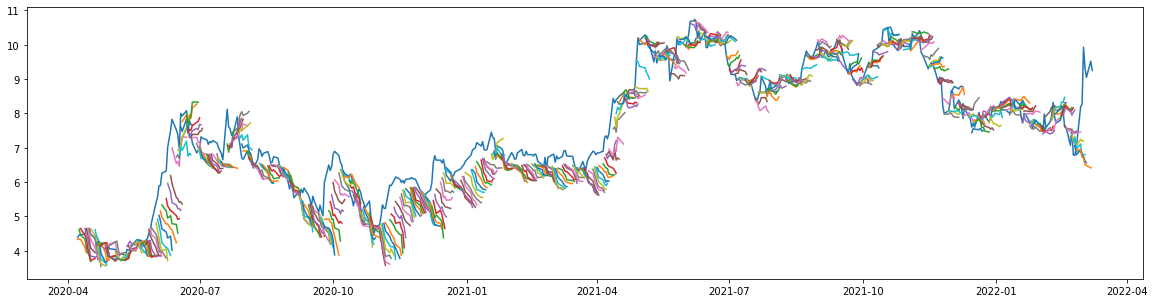

In [21]:
data = df.loc[test_split_idx+1:].Data
x_truth = data;
y_truth = test_df['Otwarcie_1day'];
plt.plot(x_truth, y_truth);
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)

30 days of history data

In [22]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label]
X_test = test_df[x_label]
y_test = test_df[y_label]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune RandomForestRegressor

In [23]:
model = MultiOutputRegressor(RandomForestRegressor())
hyperparameters = dict(estimator__bootstrap=[True], 
                     estimator__n_estimators=[200, 400, 600, 800],
                     estimator__max_depth=[20, 30, 40, 50, 60],
                     estimator__max_features=['auto', 'sqrt'],
                     estimator__min_samples_leaf=[1, 2, 4],
                     estimator__min_samples_split=[2, 5, 10])
tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor()
randomized_search = RandomizedSearchCV(model,
    hyperparameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print(hyperparameters_tuning.best_params_)

{'estimator__n_estimators': 400, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'auto', 'estimator__max_depth': 50, 'estimator__bootstrap': True}


In [24]:
model = hyperparameters_tuning.best_estimator_
y_pred = model.predict(X_test)

In [25]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 1.0954356379933898
MAE = 0.7709661130947723
RMSE = 1.046630612008549


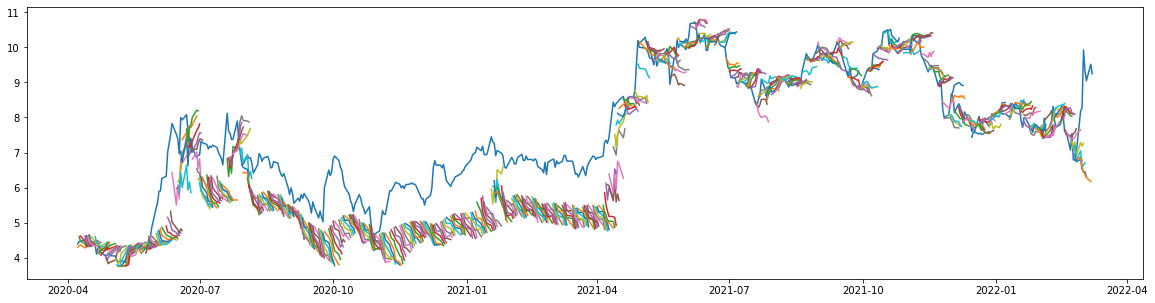

In [26]:
data = df.loc[test_split_idx+1:].Data
x_truth = data;
y_truth = test_df['Otwarcie_1day'];
plt.plot(x_truth, y_truth);
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)